<center> <h3> PROYECTO FINAL </h3> </center>

Para el proyecto final se utilizó una base de datos con información bancaria. Especificamente es la colocación de créditos de consumo de 2020 a 2021. La base cuenta con datos demograficos, financieros, y transaccionales.

Importación de librerías a utilizar

In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import botocore
import pprint
import psycopg2
import configparser
import sqlalchemy
import sql_queries2
import sql_queries3


### CREACIÓN DE BASE DE DATOS EN AWS

#### Iniciación de Variables

In [2]:
rdsIdentifier = 'proyecto-db-2' #nombre de la instancia

#### Carga de archivo de configuraciones

In [3]:
config = configparser.ConfigParser()
config.read('escec2.cfg')

['escec2.cfg']

#### Creación de Instancia de RDS 

In [4]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                     aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                     region_name='us-east-1')

#### Verificación de instancias de RDS disponibles

In [5]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['proyecto-db']


#### Creación de Servicio RDS

In [6]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS', 'DB_USER'),
            MasterUserPassword=config.get('RDS', 'DB_PASSWORD'),
            Port=int(config.get('RDS', 'DB_PORT')),
            VpcSecurityGroupIds=["sg-082d8532d37079329"],
            PubliclyAccessible=True
        )
    pprint.pprint (response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'AllocatedStorage': 10,
                'AssociatedRoles': [],
                'AutoMinorVersionUpgrade': True,
                'BackupRetentionPeriod': 1,
                'BackupTarget': 'region',
                'CACertificateIdentifier': 'rds-ca-2019',
                'CopyTagsToSnapshot': False,
                'CustomerOwnedIpEnabled': False,
                'DBInstanceArn': 'arn:aws:rds:us-east-1:556719607332:db:proyecto-db-2',
                'DBInstanceClass': 'db.t3.micro',
                'DBInstanceIdentifier': 'proyecto-db-2',
                'DBInstanceStatus': 'creating',
                'DBName': 'databanco',
                'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14',
                                       'ParameterApplyStatus': 'in-sync'}],
                'DBSecurityGroups': [],
                'DBSubnetGroup': {'DBSubnetGroupDescription': 'default',
                                  'DBSubnetGroupName': 'default',
            

##### Recordemos Esperar unos minutos para consultar la informaicón de la instancia.

##### Obtenemos URL del Host

In [7]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

proyecto-db-2.cprhtqthkgbe.us-east-1.rds.amazonaws.com


#### Ejecución de Query

In [8]:
import sql_queries2
print(sql_queries2.DDL_QUERY)


CREATE TABLE actividad
(idactividad_sk INT NOT NULL,
ActividadEconomica VARCHAR (200) NOT NULL,
SubActividadEconomica VARCHAR (50) NOT NULL,
CONSTRAINT sk_idactividad PRIMARY KEY (idactividad_sk));

CREATE TABLE producto
(producto_sk INT  NOT NULL,
FamiliaProducto VARCHAR (100) NOT NULL,
CONSTRAINT sk_producto PRIMARY KEY (producto_sk));

CREATE TABLE departamento
(oficina_sk INT  NOT NULL,
oficina VARCHAR (100) NOT NULL,
region VARCHAR (100) NOT NULL,
CONSTRAINT sk_oficina PRIMARY KEY (oficina_sk));

CREATE TABLE cliente
(IdCliente_sk INT  NOT NULL,
edad INT NOT NULL,
RangoEdad VARCHAR(50),
Genero VARCHAR (50),
EstadoCivil VARCHAR (50),
CONSTRAINT sk_IdCliente PRIMARY KEY (IdCliente_sk));

CREATE TABLE fac_table
(idactividad_sk INT NOT NULL,
producto_sk INT NOT NULL,
oficina_sk INT NOT NULL,
IdCliente_sk INT NOT NULL,
NumeroCredito BIGINT NOT NULL,
Cosecha INT NOT NULL,
FechaDesembolso DATE NOT NULL,
MontoCredito NUMERIC (20,2) NOT NULL,
CuotaCredito NUMERIC (20,2) NOT NULL,
Plazo IN

##### Conexión a Base de Datos desde Python

In [9]:
import sql_queries2

try:
    db_conn = psycopg2.connect(
        database=config.get('RDS', 'DB_NAME'), 
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('RDS', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_queries2.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


### USO DE COMANDOS DDL

#### Inserción de datos de S3 - Tabla Actividad

In [28]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

In [29]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

mibucket-cdp-22000347


In [19]:
S3_BUCKET_NAME = 'mibucket-cdp-22000347'

In [30]:
#extraemos todo lo que está en el bucket
remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

['Actividad.xlsx']

In [31]:
import io

In [32]:
for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_actividad = pd.read_excel(io.BytesIO(data), engine='openpyxl')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_actividad.head()

idactividad_sk actividadeconomica subactividadeconomica
0               1        DEPENDIENTE                FORMAL
1               2        DEPENDIENTE              INFORMAL
2               3        DEPENDIENTE              JUBILADO
3               4        DEPENDIENTE                RENTAS
4               5      INDEPENDIENTE            PENSIONADO

#### Inserción de datos a la base

Actividad

In [33]:
tipoactividad = 'actividad'
postgres_driver= f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""
###df_data=pd.DataFrame.from_records(data_dict)
df_actividad.to_sql(tipoactividad,postgres_driver, index=False, if_exists='append')

8

Producto

In [34]:
def insertDataToSQL(data_dict, table_name):
     postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""    
     df_data = pd.DataFrame.from_records(data_dict)
     try:
          response = df_data.to_sql(table_name, postgres_driver, index=False, if_exists='append')
          print(f'Se han insertado {response} nuevos registros.' )
     except Exception as ex:
          print(ex)

In [35]:
data_tipo_producto = [
     {'producto_sk': 1,'familiaproducto': 'BLANCA',  }, 
     {'producto_sk': 2, 'familiaproducto': 'COMPUTACION',},
     {'producto_sk': 3, 'familiaproducto': 'ELECTRONICA',},
     {'producto_sk': 4, 'familiaproducto': 'MUEBLES',},
     {'producto_sk': 5, 'familiaproducto': 'OTRAS'},
     {'producto_sk': 6, 'familiaproducto': 'TELEFONIA'},
     {'producto_sk': 7, 'familiaproducto': 'VEHICULOS'}
     ]

#insertamos data en tabla tipo_transaccione 
insertDataToSQL(data_tipo_producto, 'producto')

Se han insertado 7 nuevos registros.


Cliente

In [36]:
#Leer Excel
df_data_cliente= pd.read_excel("cliente2.xlsx")

In [37]:
df_data_cliente

idcliente_sk  edad     rangoedad     genero  estadocivil
0            509580    51  Generación X   FEMENINO      SOLTERO
1            634346    21  Generación Z   FEMENINO       CASADO
2            620247    42  Generación X  MASCULINO       CASADO
3            634342    50  Generación X  MASCULINO  UNION LIBRE
4            545552    29   Millennials   FEMENINO  UNION LIBRE
...             ...   ...           ...        ...          ...
17167        666369    26   Millennials  MASCULINO      SOLTERO
17168        650053    23  Generación Z  MASCULINO      SOLTERO
17169        301512    45  Generación X  MASCULINO      SOLTERO
17170        483060    41  Generación X  MASCULINO      SOLTERO
17171        626013    35   Millennials  MASCULINO      SOLTERO

[17172 rows x 5 columns]

In [38]:
cliente = 'cliente'
postgres_driver= f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""
###df_data=pd.DataFrame.from_records(data_dict)
df_data_cliente.to_sql(cliente,postgres_driver, index=False, if_exists='append')

172

Departamento

In [39]:
#Leer Excel
df_data_departamento= pd.read_excel("departamento.xlsx")

In [40]:
departamento = 'departamento'
postgres_driver= f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""
###df_data=pd.DataFrame.from_records(data_dict)
df_data_departamento.to_sql(departamento,postgres_driver, index=False, if_exists='append')

22

Tabla de hechos

In [41]:
#Leer Excel
df_data_fact_table= pd.read_excel("facttable.xlsx")

In [42]:
facttable = 'fac_table'
postgres_driver= f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""
###df_data=pd.DataFrame.from_records(data_dict)
df_data_fact_table.to_sql(facttable,postgres_driver, index=False, if_exists='append')

274

In [43]:
df_data_fact_table

idactividad_sk  producto_sk  oficina_sk  idcliente_sk  \
0                   8            6          20        509580   
1                   7            1           2        634346   
2                   1            4           2        620247   
3                   3            2           2        634342   
4                   7            4           2        545552   
...               ...          ...         ...           ...   
19269               2            4           2        632686   
19270               7            1           7        605390   
19271               1            3           7        604204   
19272               7            4          10        626013   
19273               7            4           7        413999   

          numerocredito  cosecha fechadesembolso  montocredito  cuotacredito  \
0         4112001183360   202006      2020-06-04      14961.09         996.0   
1         4112001183378   202006      2020-06-04       1844.22         193.0   
2         4112001183386   202006      2020-06-04       3843.27         448.0   
3         4112001183394   202006      2020-06-04       5198.57         989.0   
4         4112001183408   202006      2020-06-04       5721.16         455.0   
...                 ...      ...             ...           ...           ...   
19269  6001105000020330   202107      2021-07-01       3287.80         402.0   
19270  6001105000020325   202107      2021-07-01      14870.09        1646.0   
19271  6001105000018620   202107      2021-07-12       3317.90         645.0   
19272  6001105000014096   202107      2021-07-31      10673.63         975.0   
19273  6001105000001385   202107      2021-07-05      10942.47        2101.0   

       plazo tipovivienda  
0         24     PRESTADA  
1         18    NO PROPIA  
2         12       PROPIA  
3          6       PROPIA  
4         18     PRESTADA  
...      ...          ...  
19269     12     PRESTADA  
19270     12       PROPIA  
19271      6    NO PROPIA  
19272     18     FAMILIAR  
19273     30       PROPIA  

[19274 rows x 11 columns]

In [45]:
import sql_queries3
print(sql_queries3.DDL_QUERY3)


CREATE TABLE facturacion
(idactividad_sk INT NOT NULL,
facturacion VARCHAR (200) NOT NULL,
CONSTRAINT sk_idfacturacion PRIMARY KEY (idactividad_sk));


In [47]:
import sql_queries3

try:
    db_conn = psycopg2.connect(
        database=config.get('RDS', 'DB_NAME'), 
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('RDS', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_queries3.DDL_QUERY3)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


Facturación

In [48]:
#Leer Excel
df_facturacion= pd.read_excel("facturacion.xlsx")

In [50]:
facturacion = 'facturacion'
postgres_driver= f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""
###df_data=pd.DataFrame.from_records(data_dict)
df_facturacion.to_sql(facturacion,postgres_driver, index=False, if_exists='append')

8

### CREACIÓN DE DATAWAREHOUSE

In [4]:
cantidad_clientes = np.random.randint(500, 20000) #cantidad de clientes a crear
rdsIdentifier = 'proyecto-dw-2' #nombre de la instancia
fake = Faker() #inicialización para creación de data random

In [5]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                     aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                     region_name='us-east-1')

In [6]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds ['proyecto-db-2', 'proyecto-dw']


In [7]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('RDS', 'DB_NAME'),
            DBInstanceIdentifier=rdsIdentifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('RDS', 'DB_USER'),
            MasterUserPassword=config.get('RDS', 'DB_PASSWORD'),
            Port=int(config.get('RDS', 'DB_PORT')),
            VpcSecurityGroupIds=["sg-082d8532d37079329"],
            PubliclyAccessible=True
        )
    pprint.pprint (response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'AllocatedStorage': 10,
                'AssociatedRoles': [],
                'AutoMinorVersionUpgrade': True,
                'BackupRetentionPeriod': 1,
                'BackupTarget': 'region',
                'CACertificateIdentifier': 'rds-ca-2019',
                'CopyTagsToSnapshot': False,
                'CustomerOwnedIpEnabled': False,
                'DBInstanceArn': 'arn:aws:rds:us-east-1:556719607332:db:proyecto-dw-2',
                'DBInstanceClass': 'db.t3.micro',
                'DBInstanceIdentifier': 'proyecto-dw-2',
                'DBInstanceStatus': 'creating',
                'DBName': 'databanco',
                'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14',
                                       'ParameterApplyStatus': 'in-sync'}],
                'DBSecurityGroups': [],
                'DBSubnetGroup': {'DBSubnetGroupDescription': 'default',
                                  'DBSubnetGroupName': 'default',
            

In [8]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rdsIdentifier)
     RDS_HOSTDW = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOSTDW)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

proyecto-dw-2.cprhtqthkgbe.us-east-1.rds.amazonaws.com


In [9]:
import sql_queriesdw
print(sql_queriesdw.DDL_QUERYDW)


CREATE TABLE actividad_facturacion
(idactividad_sk INT NOT NULL,
actividadeconomica VARCHAR (200) NOT NULL,
subactividadeconomica VARCHAR (50) NOT NULL,
facturacion VARCHAR (50) NOT NULL,
CONSTRAINT sk_idactividad PRIMARY KEY (idactividad_sk));

CREATE TABLE producto
(producto_sk INT  NOT NULL,
FamiliaProducto VARCHAR (100) NOT NULL,
CONSTRAINT sk_producto PRIMARY KEY (producto_sk));

CREATE TABLE departamento
(oficina_sk INT  NOT NULL,
oficina VARCHAR (100) NOT NULL,
region VARCHAR (100) NOT NULL,
CONSTRAINT sk_oficina PRIMARY KEY (oficina_sk));

CREATE TABLE cliente
(IdCliente_sk INT  NOT NULL,
edad INT NOT NULL,
RangoEdad VARCHAR(50),
Genero VARCHAR (50),
EstadoCivil VARCHAR (50),
CONSTRAINT sk_IdCliente PRIMARY KEY (IdCliente_sk));

CREATE TABLE fac_table
(idactividad_sk INT NOT NULL,
producto_sk INT NOT NULL,
oficina_sk INT NOT NULL,
IdCliente_sk INT NOT NULL,
NumeroCredito BIGINT NOT NULL,
Cosecha INT NOT NULL,
FechaDesembolso DATE NOT NULL,
MontoCredito NUMERIC (20,2) NOT NULL,

In [10]:
import sql_queriesdw

try:
    db_conn = psycopg2.connect(
        database=config.get('RDS', 'DB_NAME'), 
        user=config.get('RDS', 'DB_USER'),
        password=config.get('RDS', 'DB_PASSWORD'), 
        host=RDS_HOSTDW,
        port=config.get('RDS', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(sql_queriesdw.DDL_QUERYDW)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


Extraer la información de la base de datos para el DWH

In [15]:
config = configparser.ConfigParser()
config.read('escec2.cfg')

['escec2.cfg']

In [16]:
RDS_HOST = 'proyecto-db-2.cprhtqthkgbe.us-east-1.rds.amazonaws.com'
#RDS_HOST=config.get('DW', 'RDS_HOST')
#RDS_HOST
print(RDS_HOST)

proyecto-db-2.cprhtqthkgbe.us-east-1.rds.amazonaws.com


In [17]:
postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""  

In [20]:
sql_query = 'SELECT * FROM actividad;'
df_actividad = pd.read_sql(sql_query, postgres_driver)
df_actividad.head()

idactividad_sk actividadeconomica subactividadeconomica
0               1        DEPENDIENTE                FORMAL
1               2        DEPENDIENTE              INFORMAL
2               3        DEPENDIENTE              JUBILADO
3               4        DEPENDIENTE                RENTAS
4               5      INDEPENDIENTE            PENSIONADO

In [21]:
sql_query = 'SELECT * FROM facturacion;'
df_facturacion = pd.read_sql(sql_query, postgres_driver)
df_facturacion.head()

idactividad_sk facturacion
0               1         FEL
1               2   NOFACTURA
2               3         FEL
3               4         FEL
4               5   NOFACTURA

Unión de tablas para generar la dimensión Actividad - Facturación

In [23]:
df_actividad_facturacion = df_actividad.merge(df_facturacion, on='idactividad_sk', how='inner')
df_actividad_facturacion.head()

idactividad_sk actividadeconomica subactividadeconomica facturacion
0               1        DEPENDIENTE                FORMAL         FEL
1               2        DEPENDIENTE              INFORMAL   NOFACTURA
2               3        DEPENDIENTE              JUBILADO         FEL
3               4        DEPENDIENTE                RENTAS         FEL
4               5      INDEPENDIENTE            PENSIONADO   NOFACTURA

In [24]:
sql_query = 'SELECT * FROM cliente;'
df_cliente = pd.read_sql(sql_query, postgres_driver)
df_cliente.head()

idcliente_sk  edad     rangoedad     genero  estadocivil
0        509580    51  Generación X   FEMENINO      SOLTERO
1        634346    21  Generación Z   FEMENINO       CASADO
2        620247    42  Generación X  MASCULINO       CASADO
3        634342    50  Generación X  MASCULINO  UNION LIBRE
4        545552    29   Millennials   FEMENINO  UNION LIBRE

In [25]:
sql_query = 'SELECT * FROM departamento;'
df_departamento = pd.read_sql(sql_query, postgres_driver)
df_departamento.head()

oficina_sk        oficina         region
0          20  SUCHITEPEQUEZ  SUR-OCCIDENTE
1           2   BAJA VERAPAZ    NOR-ORIENTE
2          16   SACATEPEQUEZ  METROPOLITANA
3           7      GUATEMALA  METROPOLITANA
4          10         JALAPA    NOR-ORIENTE

In [26]:
sql_query = 'SELECT * FROM producto;'
df_producto = pd.read_sql(sql_query, postgres_driver)
df_producto.head()

producto_sk familiaproducto
0            1          BLANCA
1            2     COMPUTACION
2            3     ELECTRONICA
3            4         MUEBLES
4            5           OTRAS

In [28]:
sql_query = 'SELECT * FROM fac_table;'
df_fact_table = pd.read_sql(sql_query, postgres_driver)
df_fact_table.head()

idactividad_sk  producto_sk  oficina_sk  idcliente_sk  numerocredito  \
0               8            6          20        509580  4112001183360   
1               7            1           2        634346  4112001183378   
2               1            4           2        620247  4112001183386   
3               3            2           2        634342  4112001183394   
4               7            4           2        545552  4112001183408   

   cosecha fechadesembolso  montocredito  cuotacredito  plazo tipovivienda  
0   202006      2020-06-04      14961.09         996.0     24     PRESTADA  
1   202006      2020-06-04       1844.22         193.0     18    NO PROPIA  
2   202006      2020-06-04       3843.27         448.0     12       PROPIA  
3   202006      2020-06-04       5198.57         989.0      6       PROPIA  
4   202006      2020-06-04       5721.16         455.0     18     PRESTADA

Inserción de datos

In [29]:
postgres_driver = f"""postgresql://{config.get('RDS', 'DB_USER')}:{config.get('RDS', 'DB_PASSWORD')}@{RDS_HOSTDW}:{config.get('RDS', 'DB_PORT')}/{config.get('RDS', 'DB_NAME')}"""  

In [30]:
#insertamos actividad_facturacion.
df_actividad_facturacion.to_sql('actividad_facturacion', postgres_driver, index=False, if_exists='append')


8

In [31]:
#insertamos cliente.
df_cliente.to_sql('cliente', postgres_driver, index=False, if_exists='append')

172

In [32]:
#insertamos producto.
df_producto.to_sql('producto', postgres_driver, index=False, if_exists='append')

7

In [33]:
#insertamos departamento.
df_departamento.to_sql('departamento', postgres_driver, index=False, if_exists='append')

22

In [34]:
#insertamos tabla de hechos.
df_fact_table.to_sql('fac_table', postgres_driver, index=False, if_exists='append')

274

### SOLUCIÓN DE PREGUNTAS

1. ¿Cuál es la distribución de créditos colocados por tipo de vivienda?


In [47]:
Agrupacion_productos = df_fact_table.groupby('tipovivienda').agg({'montocredito': 'count'}).reset_index()
Agrupacion_productosOrdenado = Agrupacion_productos.sort_values('montocredito',ascending=False)
Agrupacion_productosOrdenado

tipovivienda  montocredito
0           FAMILIAR          8400
3             PROPIA          4262
2           PRESTADA          3455
1          NO PROPIA          3149
4  PROPIA HIPOTECADA             8

2. ¿Cual es el top de departamentos en donde más créditos se desembolsan?

In [50]:
df_fact_departamento = df_fact_table.merge(df_departamento, on='oficina_sk', how='inner')

Agrupacion_departamento = df_fact_departamento.groupby('oficina').agg({'montocredito': 'count'}).reset_index()
Agrupacion_departamentoOrdenado = Agrupacion_departamento.sort_values('montocredito',ascending=False)
Agrupacion_departamentoOrdenado.head()


oficina  montocredito
6        GUATEMALA          8135
5        ESCUINTLA          2494
12  QUETZALTENANGO          1496
14      RETALHULEU           829
19   SUCHITEPEQUEZ           796

3. ¿Cual es el monto promedio desembolsado por tipo de producto?

In [58]:
df_fact_producto = df_fact_table.merge(df_producto, on='producto_sk', how='inner')

Agrupacion_producto = df_fact_producto.groupby('familiaproducto').agg({'montocredito': 'mean'}).reset_index()
Agrupacion_productoOrdenado = Agrupacion_producto.sort_values('montocredito',ascending=False)
Agrupacion_productoOrdenado

familiaproducto  montocredito
6       VEHICULOS  12682.786719
3         MUEBLES   9175.587787
0          BLANCA   8723.452422
4           OTRAS   8534.950588
1     COMPUTACION   8417.507625
2     ELECTRONICA   8020.271070
5       TELEFONIA   5929.257917

4.¿Que generación es la que solicita más créditos?

In [59]:
df_fact_cliente = df_fact_table.merge(df_cliente, on='idcliente_sk', how='inner')

Agrupacion_cliente = df_fact_cliente.groupby('rangoedad').agg({'montocredito': 'count'}).reset_index()
Agrupacion_clienteordenado = Agrupacion_cliente.sort_values('montocredito',ascending=False)
Agrupacion_clienteordenado

rangoedad  montocredito
3   Millennials         10547
1  Generación X          4747
2  Generación Z          2495
0   Baby Boomer          1485

5. Hacer un gráfico de barras con la colocación mensual de créditos.

In [61]:
import matplotlib.pyplot as plt

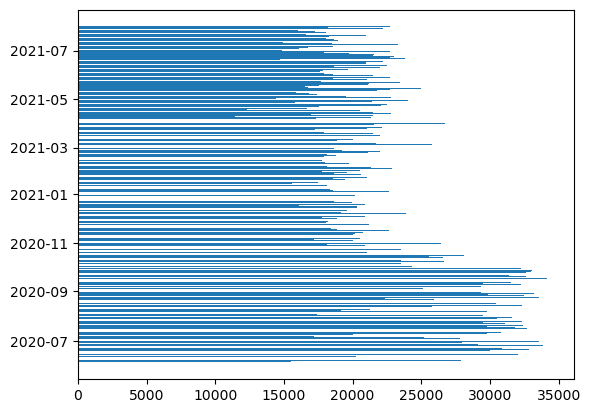

In [63]:
plt.barh(df_fact_table['fechadesembolso'], df_fact_table['montocredito'])
plt.show()